In [1]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')
     


2025-05-01 15:06:56.420875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746112016.672239      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746112016.732055      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# utility functions

In [4]:
import torch
import numpy as np

def validate_model(model, val_dataset, tolerance=0.1, device='cuda'):
    model.eval()
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    val_losses = []
    val_accuracies = []
    reconstruction_errors = []

    with torch.no_grad():
        for seq_true in val_dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            # Compute loss (reconstruction error)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

            # Compute accuracy
            abs_error = torch.abs(seq_true - seq_pred)
            correct = (abs_error < tolerance).float()
            accuracy = correct.mean().item() * 100
            val_accuracies.append(accuracy)

            # Store per-sample reconstruction errors (mean over sequence)
            mean_error = abs_error.mean(dim=-1).cpu().numpy()  # Mean over sequence length
            reconstruction_errors.extend(mean_error)

    avg_val_loss = np.mean(val_losses)
    avg_val_acc = np.mean(val_accuracies)
    reconstruction_errors = np.array(reconstruction_errors)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.2f}%")
    print(f"Mean Reconstruction Error: {np.mean(reconstruction_errors):.4f}")
    print(f"Std Reconstruction Error: {np.std(reconstruction_errors):.4f}")

    return reconstruction_errors


In [6]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[0].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()

In [8]:
import matplotlib.pyplot as plt

def plot_convergence(history, save_path='convergence_plot.png'):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (L1)')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Convergence')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


In [9]:
import torch
import numpy as np
import copy

def train_model(model, train_dataset, val_dataset, n_epochs, save_path, patience=10, tolerance=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []
        train_accuracies = []

        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            # Compute loss
            loss = criterion(seq_pred, seq_true)

            # Compute accuracy
            abs_error = torch.abs(seq_true - seq_pred)
            correct = (abs_error < tolerance).float()
            accuracy = correct.mean().item() * 100

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accuracies.append(accuracy)

        model.eval()
        val_losses = []
        val_accuracies = []
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)

                abs_error = torch.abs(seq_true - seq_pred)
                correct = (abs_error < tolerance).float()
                accuracy = correct.mean().item() * 100

                val_losses.append(loss.item())
                val_accuracies.append(accuracy)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_acc = np.mean(train_accuracies)
        val_acc = np.mean(val_accuracies)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print("Saving best model.")
        else:
            patience_counter += 1
            print(f"No improvement. Patience {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

        if epoch == 1 or epoch % 5 == 0:
            plot_input_reconstruction(model, val_dataset, epoch)

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model.eval(), history


In [10]:
def get_reconstruction_errors(model, dataset, threshold, device='cuda'):
    model.eval()
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    errors = []
    predictions = []

    with torch.no_grad():
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            abs_error = torch.abs(seq_true - seq_pred)
            mean_error = abs_error.mean(dim=-1).cpu().numpy()  # mean over sequence
            errors.extend(mean_error)

            # Predict anomaly if error > threshold
            is_anomaly = mean_error > threshold
            predictions.extend(is_anomaly)

    return np.array(errors), np.array(predictions)

# Exploratory Data Analysis and Visualization of ECG Data

## data loading

In [11]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## EDA

In [12]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


In [13]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
136    0
137    0
138    0
139    0
140    0
Length: 141, dtype: int64

In [14]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
136    float64
137    float64
138    float64
139    float64
140    float64
Length: 141, dtype: object

In [15]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
     

In [16]:
print(new_columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 'target']


In [17]:
df.target.value_counts()

target
1.0    2919
0.0    2079
Name: count, dtype: int64

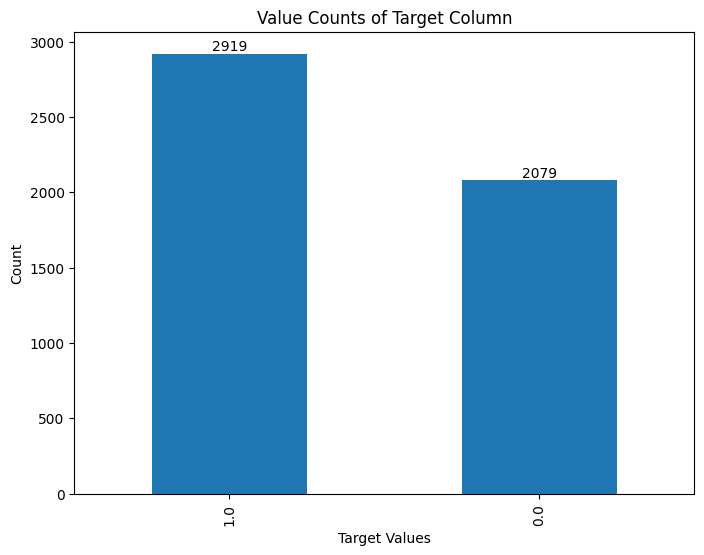

In [18]:
value_counts = df['target'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()
     


In [19]:

classes = df.target.unique()

def plot_ecg(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='black', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    # Set the title
    ax.set_title(class_name)

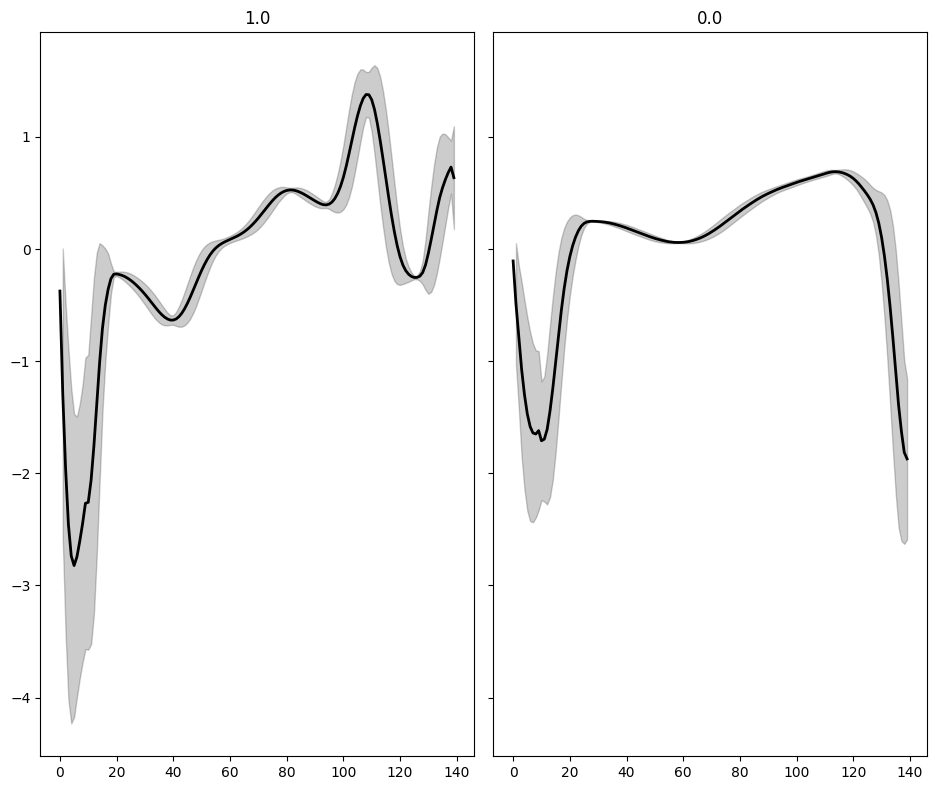

In [20]:

# Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_ecg(data, cls, ax)  

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()

# Data preprocessing and Splitting 

In [22]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [23]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(2079, 140)

In [ ]:
# Splitting the Dataset

# Initial Train-Validation Split:
# The dataset 'normal_df' is divided into training and validation sets.
# 15% of the data is allocated to the validation set.

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)

# Further Splitting for Validation and Test:
# The validation set obtained in the previous step is further split into validation and test sets.
# 33% of the validation set is allocated to the test set.
# The same 'random_state=42' is used for consistency in randomization.

val_df, test_df = train_test_split(
  val_df,
  test_size=0.30,
  random_state=42
)

In [25]:
# Function to Create a Dataset
def create_dataset(df):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features
     


In [26]:
# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)
     


In [30]:
print(type(train_dataset))
print(len(train_dataset))
print(train_dataset[0])  # to look at the first element


<class 'list'>
2481
tensor([[-0.6586],
        [-3.3663],
        [-4.4705],
        [-4.4366],
        [-3.9803],
        [-3.2074],
        [-1.9096],
        [-1.4762],
        [-1.1765],
        [-0.4146],
        [-0.2211],
        [-0.1805],
        [-0.1930],
        [-0.1874],
        [-0.3086],
        [-0.2386],
        [-0.1570],
        [-0.1155],
        [-0.1383],
        [-0.2386],
        [-0.2414],
        [-0.2443],
        [-0.1908],
        [-0.2760],
        [-0.3302],
        [-0.3732],
        [-0.3839],
        [-0.4806],
        [-0.4453],
        [-0.5132],
        [-0.5459],
        [-0.6757],
        [-0.6768],
        [-0.7308],
        [-0.7282],
        [-0.7732],
        [-0.7138],
        [-0.7390],
        [-0.6947],
        [-0.5829],
        [-0.5307],
        [-0.4837],
        [-0.4254],
        [-0.2301],
        [-0.1463],
        [ 0.0123],
        [ 0.0823],
        [ 0.2004],
        [ 0.2090],
        [ 0.1468],
        [ 0.1720],
        [ 0

# Modeling 

## model 1 : lstm auto encoder

### moel architecture

In [31]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))
     

In [32]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)
     

In [33]:
class Autoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)

In [35]:
device

device(type='cuda')

### Training

Epoch 1: Train Loss 60.4272, Val Loss 52.6299, Train Acc 23.66%, Val Acc 29.49%
Saving best model.


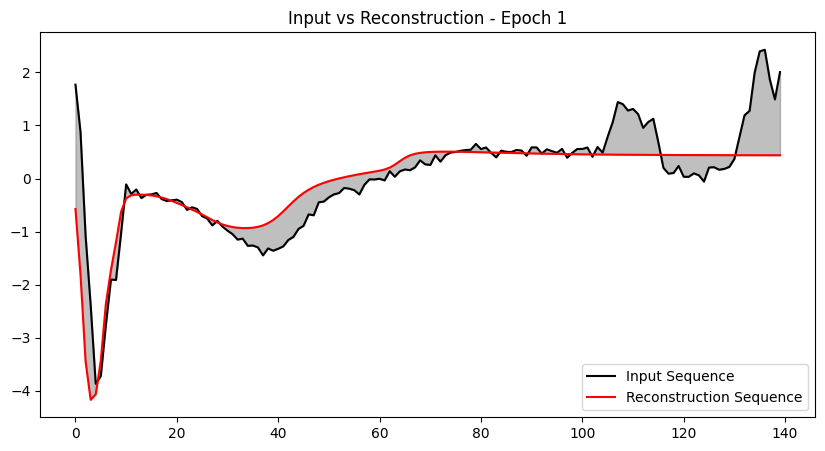

Epoch 2: Train Loss 51.0786, Val Loss 48.3214, Train Acc 30.56%, Val Acc 31.83%
Saving best model.
Epoch 3: Train Loss 46.5420, Val Loss 41.0786, Train Acc 33.97%, Val Acc 35.82%
Saving best model.
Epoch 4: Train Loss 33.5051, Val Loss 37.7846, Train Acc 42.31%, Val Acc 40.07%
Saving best model.
Epoch 5: Train Loss 29.4046, Val Loss 31.5584, Train Acc 46.46%, Val Acc 43.61%
Saving best model.


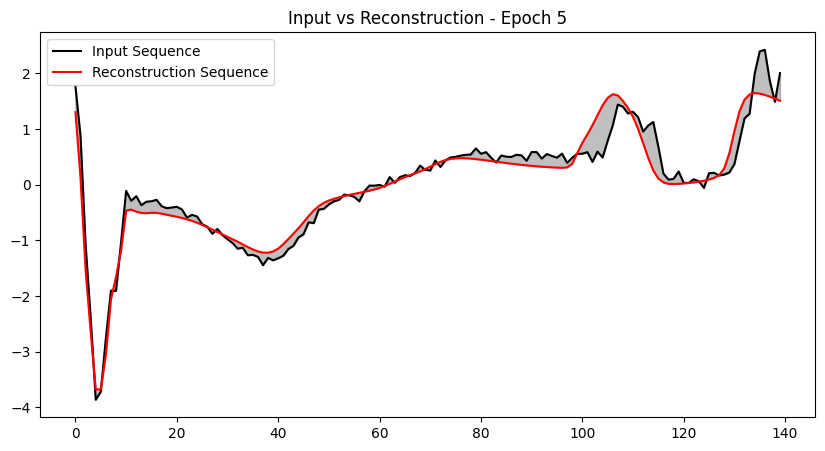

Epoch 6: Train Loss 28.0502, Val Loss 26.2167, Train Acc 47.63%, Val Acc 46.52%
Saving best model.
Epoch 7: Train Loss 27.3610, Val Loss 29.1024, Train Acc 48.28%, Val Acc 46.65%
No improvement. Patience 1/10
Epoch 8: Train Loss 26.1544, Val Loss 30.8176, Train Acc 49.76%, Val Acc 42.02%
No improvement. Patience 2/10
Epoch 9: Train Loss 25.1829, Val Loss 24.1002, Train Acc 50.72%, Val Acc 50.32%
Saving best model.
Epoch 10: Train Loss 24.5527, Val Loss 23.1064, Train Acc 51.18%, Val Acc 51.75%
Saving best model.


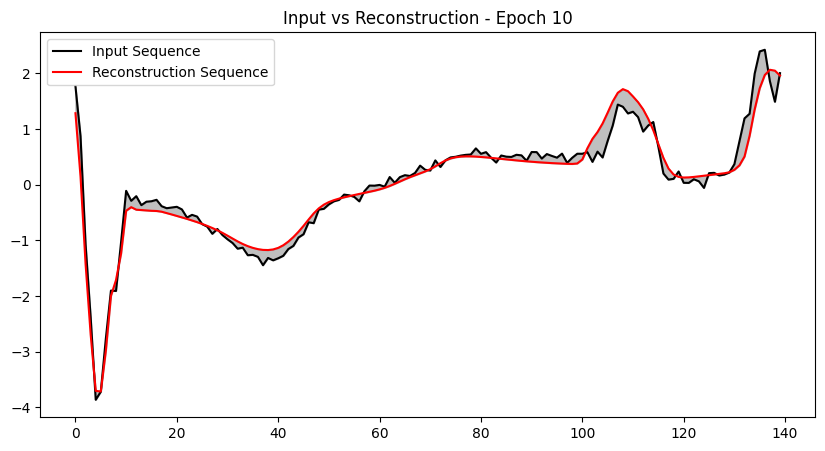

Epoch 11: Train Loss 25.2920, Val Loss 24.8526, Train Acc 50.54%, Val Acc 46.83%
No improvement. Patience 1/10
Epoch 12: Train Loss 24.1869, Val Loss 22.8026, Train Acc 52.05%, Val Acc 50.38%
Saving best model.
Epoch 13: Train Loss 24.3760, Val Loss 25.7114, Train Acc 51.42%, Val Acc 48.89%
No improvement. Patience 1/10
Epoch 14: Train Loss 23.5864, Val Loss 21.9248, Train Acc 52.50%, Val Acc 53.62%
Saving best model.
Epoch 15: Train Loss 23.3968, Val Loss 21.3852, Train Acc 52.62%, Val Acc 53.84%
Saving best model.


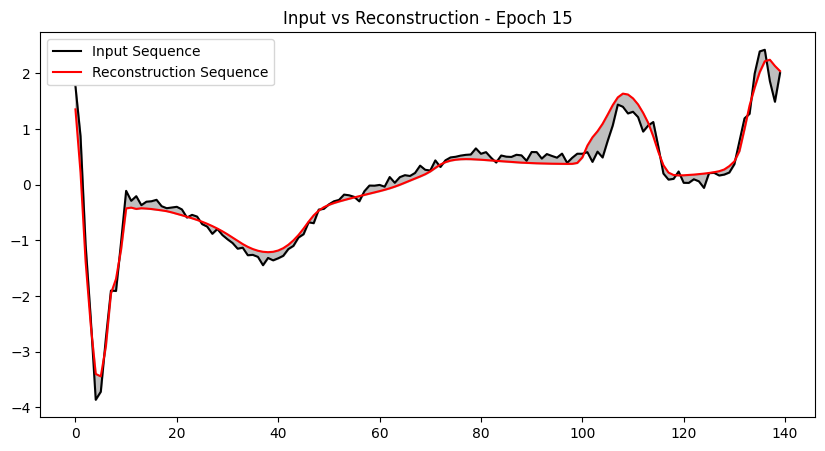

Epoch 16: Train Loss 21.9237, Val Loss 20.5736, Train Acc 54.51%, Val Acc 55.20%
Saving best model.
Epoch 17: Train Loss 22.0823, Val Loss 20.8969, Train Acc 54.29%, Val Acc 54.08%
No improvement. Patience 1/10
Epoch 18: Train Loss 21.8225, Val Loss 21.2318, Train Acc 54.67%, Val Acc 52.86%
No improvement. Patience 2/10
Epoch 19: Train Loss 20.9085, Val Loss 20.3371, Train Acc 56.08%, Val Acc 56.09%
Saving best model.
Epoch 20: Train Loss 20.4439, Val Loss 29.2756, Train Acc 56.84%, Val Acc 50.10%
No improvement. Patience 1/10


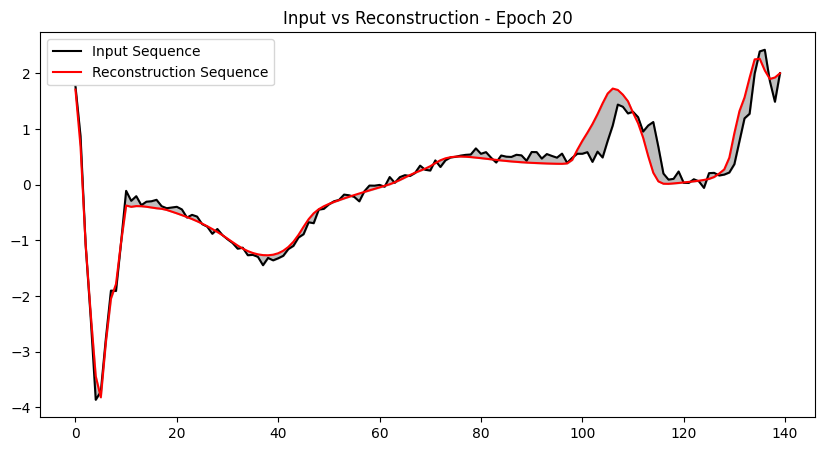

Epoch 21: Train Loss 20.2215, Val Loss 19.7517, Train Acc 57.43%, Val Acc 56.92%
Saving best model.
Epoch 22: Train Loss 19.9557, Val Loss 18.9189, Train Acc 57.75%, Val Acc 58.56%
Saving best model.
Epoch 23: Train Loss 19.6752, Val Loss 18.6768, Train Acc 58.67%, Val Acc 60.34%
Saving best model.
Epoch 24: Train Loss 19.2249, Val Loss 19.4686, Train Acc 59.35%, Val Acc 59.12%
No improvement. Patience 1/10
Epoch 25: Train Loss 18.8515, Val Loss 18.4456, Train Acc 60.22%, Val Acc 60.85%
Saving best model.


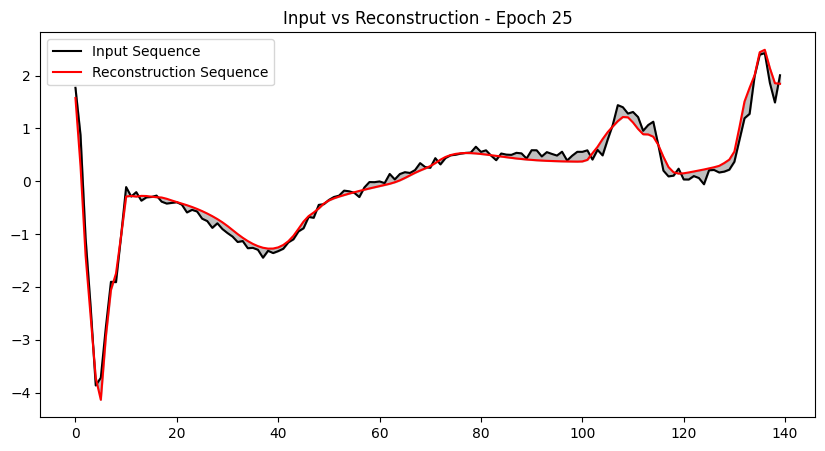

Epoch 26: Train Loss 18.5216, Val Loss 18.6109, Train Acc 60.99%, Val Acc 61.91%
No improvement. Patience 1/10
Epoch 27: Train Loss 18.2080, Val Loss 17.6026, Train Acc 61.64%, Val Acc 63.23%
Saving best model.
Epoch 28: Train Loss 18.0870, Val Loss 20.6034, Train Acc 61.76%, Val Acc 57.24%
No improvement. Patience 1/10
Epoch 29: Train Loss 17.7779, Val Loss 21.4909, Train Acc 62.14%, Val Acc 57.09%
No improvement. Patience 2/10
Epoch 30: Train Loss 17.2665, Val Loss 20.0073, Train Acc 63.00%, Val Acc 59.12%
No improvement. Patience 3/10


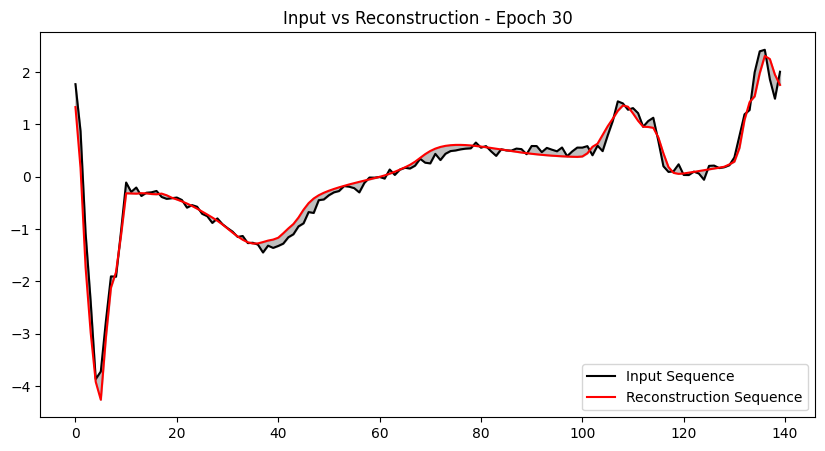

Epoch 31: Train Loss 17.2479, Val Loss 15.9652, Train Acc 62.94%, Val Acc 64.96%
Saving best model.
Epoch 32: Train Loss 16.6677, Val Loss 18.0747, Train Acc 63.55%, Val Acc 59.99%
No improvement. Patience 1/10
Epoch 33: Train Loss 16.7667, Val Loss 15.9251, Train Acc 62.91%, Val Acc 63.62%
Saving best model.
Epoch 34: Train Loss 16.1558, Val Loss 18.5572, Train Acc 63.70%, Val Acc 55.92%
No improvement. Patience 1/10
Epoch 35: Train Loss 28.8718, Val Loss 31.1961, Train Acc 50.41%, Val Acc 40.06%
No improvement. Patience 2/10


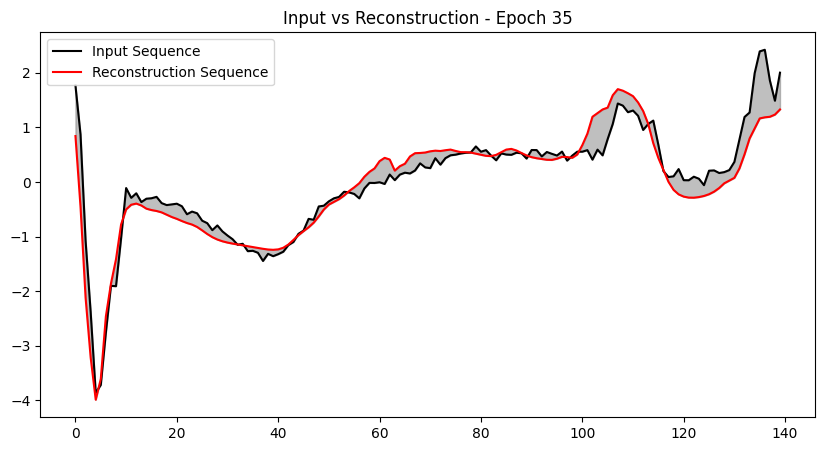

Epoch 36: Train Loss 29.7572, Val Loss 23.2638, Train Acc 44.54%, Val Acc 52.76%
No improvement. Patience 3/10
Epoch 37: Train Loss 21.7912, Val Loss 19.6498, Train Acc 54.14%, Val Acc 57.55%
No improvement. Patience 4/10
Epoch 38: Train Loss 20.0324, Val Loss 20.7376, Train Acc 56.74%, Val Acc 56.17%
No improvement. Patience 5/10
Epoch 39: Train Loss 18.9346, Val Loss 20.2004, Train Acc 58.80%, Val Acc 55.48%
No improvement. Patience 6/10
Epoch 40: Train Loss 15.3940, Val Loss 16.3802, Train Acc 65.45%, Val Acc 62.63%
No improvement. Patience 7/10


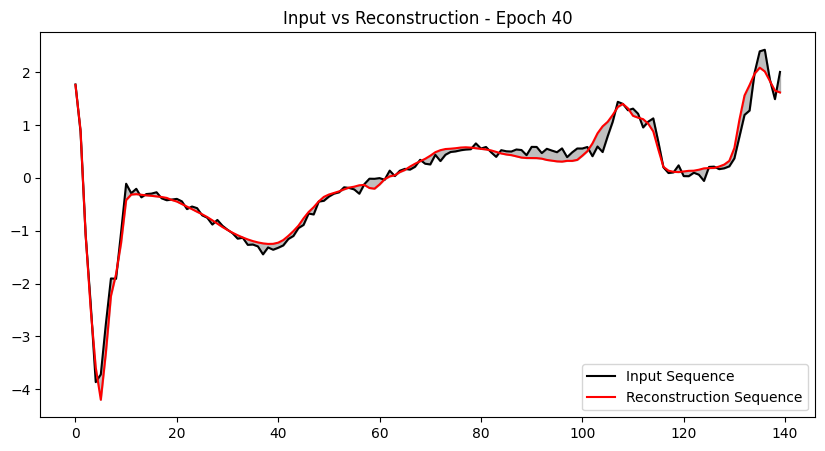

Epoch 41: Train Loss 14.5117, Val Loss 13.8748, Train Acc 66.93%, Val Acc 67.50%
Saving best model.
Epoch 42: Train Loss 14.1643, Val Loss 13.8807, Train Acc 67.63%, Val Acc 66.51%
No improvement. Patience 1/10
Epoch 43: Train Loss 13.6301, Val Loss 13.4540, Train Acc 68.74%, Val Acc 67.93%
Saving best model.
Epoch 44: Train Loss 13.1836, Val Loss 12.8200, Train Acc 69.79%, Val Acc 69.88%
Saving best model.
Epoch 45: Train Loss 13.0605, Val Loss 13.3977, Train Acc 70.05%, Val Acc 67.83%
No improvement. Patience 1/10


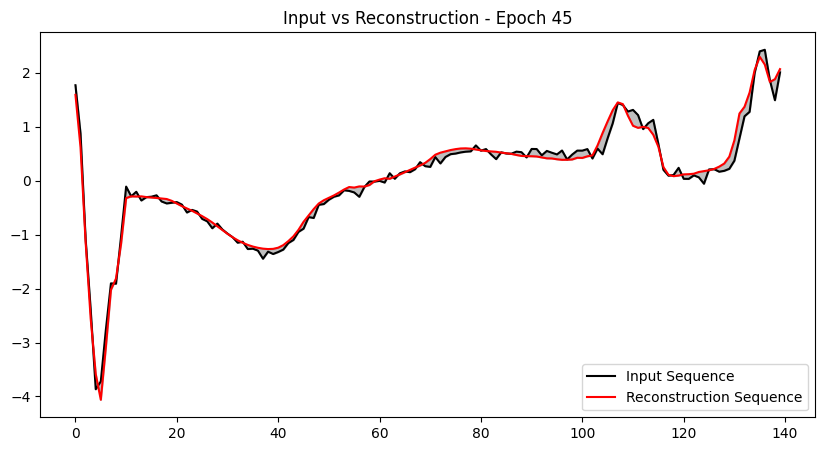

Epoch 46: Train Loss 13.1351, Val Loss 14.1953, Train Acc 69.86%, Val Acc 66.82%
No improvement. Patience 2/10
Epoch 47: Train Loss 12.6832, Val Loss 14.4023, Train Acc 70.98%, Val Acc 67.99%
No improvement. Patience 3/10
Epoch 48: Train Loss 12.6966, Val Loss 12.4160, Train Acc 70.88%, Val Acc 69.93%
Saving best model.
Epoch 49: Train Loss 12.4598, Val Loss 12.9171, Train Acc 71.48%, Val Acc 70.54%
No improvement. Patience 1/10
Epoch 50: Train Loss 12.5906, Val Loss 13.9271, Train Acc 71.29%, Val Acc 67.35%
No improvement. Patience 2/10


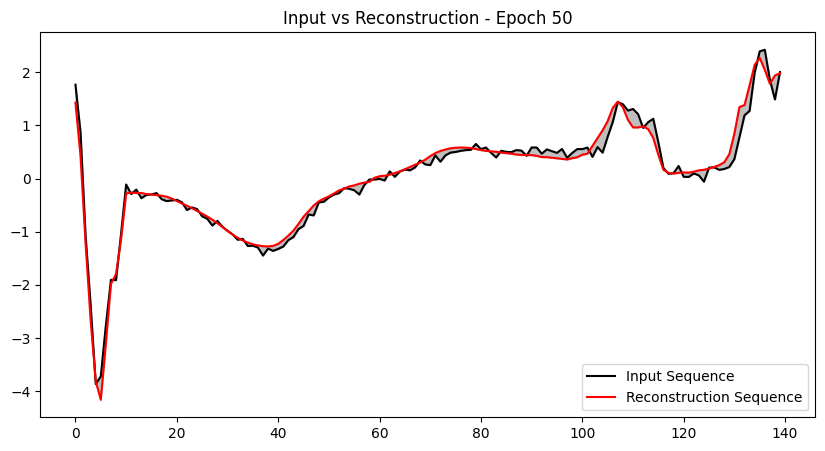

Epoch 51: Train Loss 12.3740, Val Loss 12.2622, Train Acc 71.78%, Val Acc 70.79%
Saving best model.
Epoch 52: Train Loss 12.3325, Val Loss 12.5191, Train Acc 71.89%, Val Acc 70.51%
No improvement. Patience 1/10
Epoch 53: Train Loss 12.1276, Val Loss 12.6668, Train Acc 72.39%, Val Acc 69.36%
No improvement. Patience 2/10
Epoch 54: Train Loss 12.0883, Val Loss 12.3359, Train Acc 72.43%, Val Acc 71.67%
No improvement. Patience 3/10
Epoch 55: Train Loss 12.0729, Val Loss 14.0823, Train Acc 72.78%, Val Acc 68.28%
No improvement. Patience 4/10


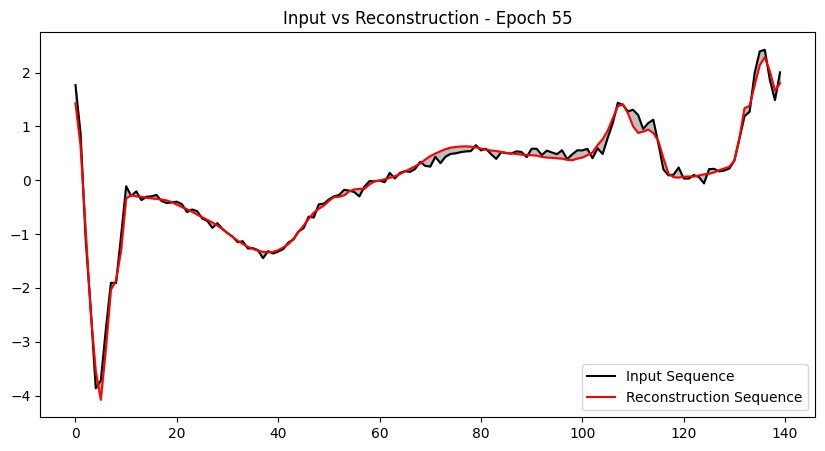

Epoch 56: Train Loss 11.9811, Val Loss 13.7277, Train Acc 72.80%, Val Acc 67.99%
No improvement. Patience 5/10
Epoch 57: Train Loss 11.8691, Val Loss 13.0884, Train Acc 73.28%, Val Acc 69.79%
No improvement. Patience 6/10
Epoch 58: Train Loss 10.5694, Val Loss 11.1058, Train Acc 76.78%, Val Acc 74.95%
Saving best model.
Epoch 59: Train Loss 10.4234, Val Loss 11.2069, Train Acc 77.23%, Val Acc 74.80%
No improvement. Patience 1/10
Epoch 60: Train Loss 10.3549, Val Loss 11.2834, Train Acc 77.51%, Val Acc 74.30%
No improvement. Patience 2/10


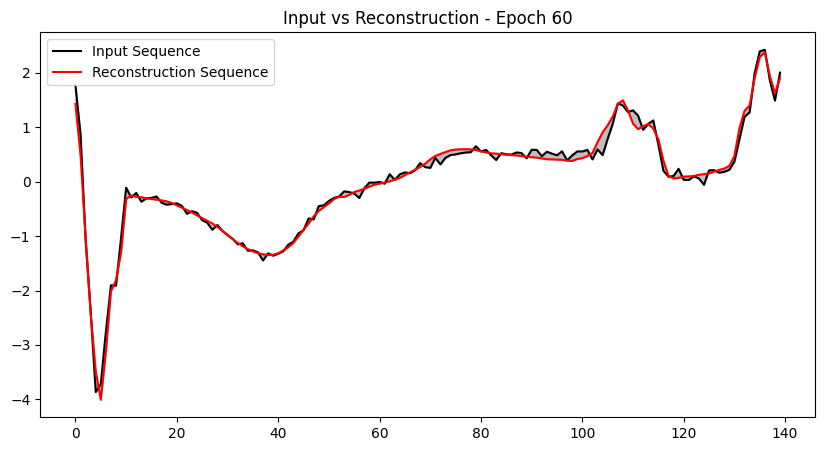

Epoch 61: Train Loss 10.2376, Val Loss 10.8929, Train Acc 77.81%, Val Acc 75.65%
Saving best model.
Epoch 62: Train Loss 10.1833, Val Loss 10.9737, Train Acc 78.06%, Val Acc 75.67%
No improvement. Patience 1/10
Epoch 63: Train Loss 10.1036, Val Loss 10.8098, Train Acc 78.40%, Val Acc 76.14%
Saving best model.
Epoch 64: Train Loss 10.0429, Val Loss 10.7391, Train Acc 78.62%, Val Acc 76.26%
Saving best model.
Epoch 65: Train Loss 9.9980, Val Loss 11.2899, Train Acc 78.84%, Val Acc 75.01%
No improvement. Patience 1/10


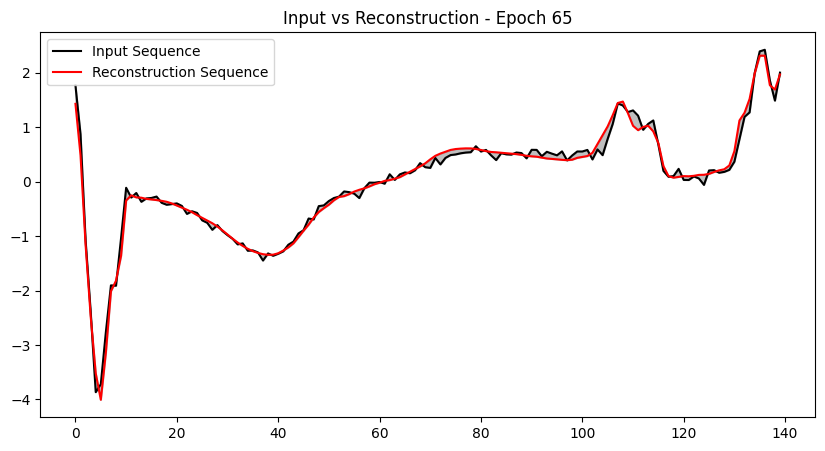

Epoch 66: Train Loss 9.9877, Val Loss 10.8032, Train Acc 79.00%, Val Acc 76.02%
No improvement. Patience 2/10
Epoch 67: Train Loss 9.7960, Val Loss 10.9309, Train Acc 79.49%, Val Acc 75.39%
No improvement. Patience 3/10
Epoch 68: Train Loss 9.7737, Val Loss 10.7372, Train Acc 79.67%, Val Acc 76.20%
Saving best model.
Epoch 69: Train Loss 9.7603, Val Loss 10.6103, Train Acc 79.73%, Val Acc 76.42%
Saving best model.
Epoch 70: Train Loss 9.6510, Val Loss 11.6475, Train Acc 80.09%, Val Acc 73.03%
No improvement. Patience 1/10


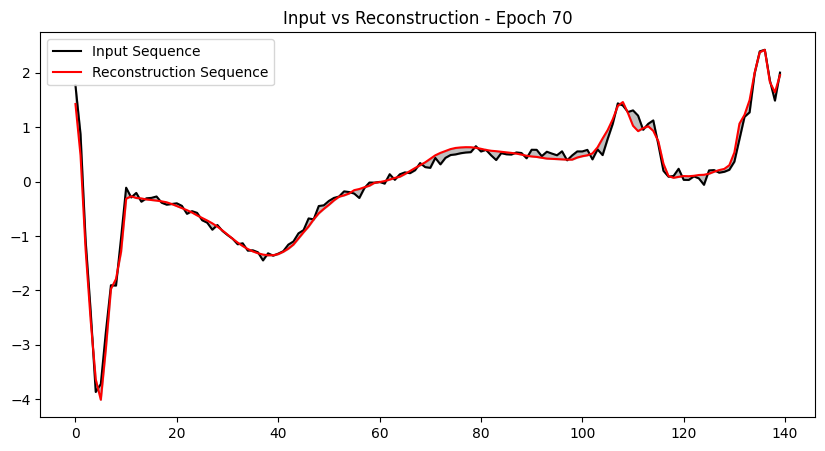

Epoch 71: Train Loss 9.6585, Val Loss 10.5313, Train Acc 80.02%, Val Acc 76.85%
Saving best model.
Epoch 72: Train Loss 9.6256, Val Loss 11.1858, Train Acc 80.19%, Val Acc 75.29%
No improvement. Patience 1/10
Epoch 73: Train Loss 9.5605, Val Loss 10.7512, Train Acc 80.40%, Val Acc 76.43%
No improvement. Patience 2/10
Epoch 74: Train Loss 9.5637, Val Loss 10.4473, Train Acc 80.36%, Val Acc 77.18%
Saving best model.
Epoch 75: Train Loss 9.4728, Val Loss 10.6175, Train Acc 80.68%, Val Acc 76.82%
No improvement. Patience 1/10


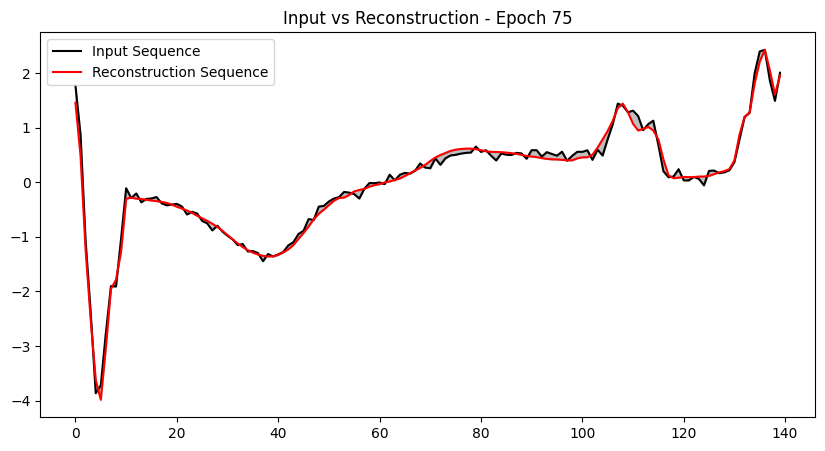

Epoch 76: Train Loss 9.4722, Val Loss 10.6681, Train Acc 80.72%, Val Acc 76.13%
No improvement. Patience 2/10
Epoch 77: Train Loss 9.4549, Val Loss 10.5311, Train Acc 80.76%, Val Acc 76.78%
No improvement. Patience 3/10
Epoch 78: Train Loss 9.3312, Val Loss 10.7908, Train Acc 81.05%, Val Acc 76.24%
No improvement. Patience 4/10
Epoch 79: Train Loss 9.3731, Val Loss 10.6516, Train Acc 80.91%, Val Acc 76.21%
No improvement. Patience 5/10
Epoch 80: Train Loss 9.3101, Val Loss 10.3596, Train Acc 81.11%, Val Acc 77.31%
Saving best model.


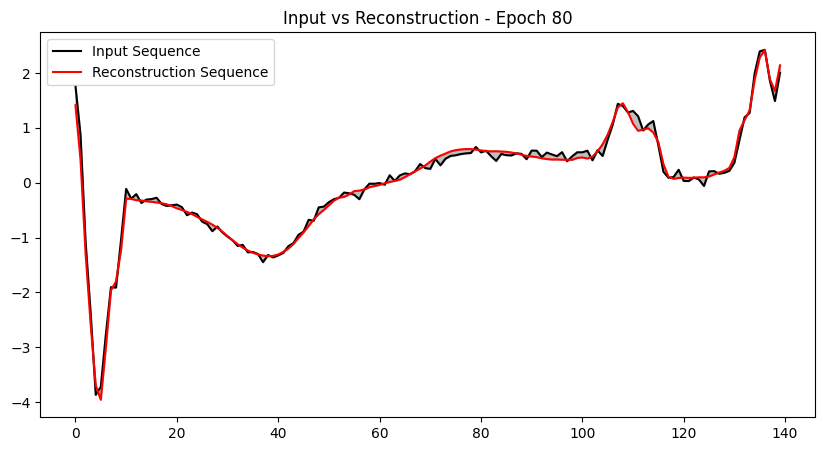

Epoch 81: Train Loss 9.3428, Val Loss 10.4717, Train Acc 81.08%, Val Acc 77.06%
No improvement. Patience 1/10
Epoch 82: Train Loss 9.2584, Val Loss 11.8912, Train Acc 81.35%, Val Acc 73.23%
No improvement. Patience 2/10
Epoch 83: Train Loss 9.2202, Val Loss 10.7193, Train Acc 81.44%, Val Acc 76.30%
No improvement. Patience 3/10
Epoch 84: Train Loss 9.2037, Val Loss 10.5966, Train Acc 81.46%, Val Acc 76.69%
No improvement. Patience 4/10
Epoch 85: Train Loss 9.1547, Val Loss 10.0968, Train Acc 81.69%, Val Acc 78.15%
Saving best model.


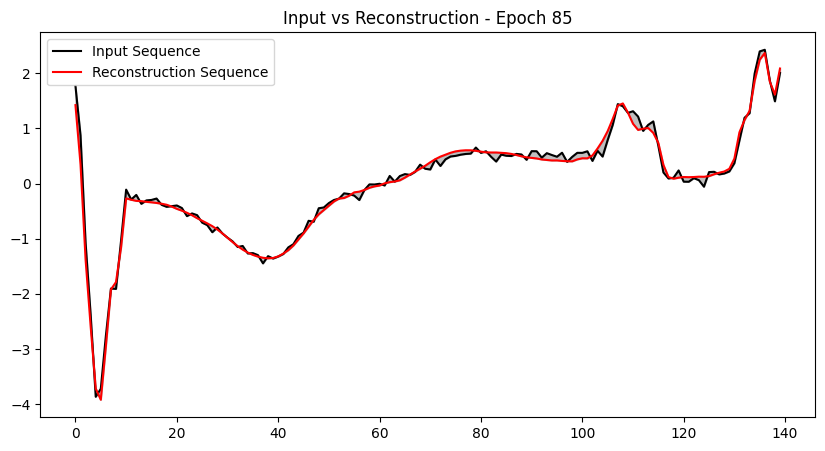

Epoch 86: Train Loss 9.1501, Val Loss 10.2379, Train Acc 81.60%, Val Acc 77.90%
No improvement. Patience 1/10
Epoch 87: Train Loss 9.1269, Val Loss 10.6773, Train Acc 81.70%, Val Acc 76.46%
No improvement. Patience 2/10
Epoch 88: Train Loss 9.2074, Val Loss 10.2765, Train Acc 81.54%, Val Acc 77.65%
No improvement. Patience 3/10
Epoch 89: Train Loss 9.1723, Val Loss 11.0123, Train Acc 81.56%, Val Acc 75.35%
No improvement. Patience 4/10
Epoch 90: Train Loss 9.0950, Val Loss 10.1758, Train Acc 81.83%, Val Acc 78.21%
No improvement. Patience 5/10


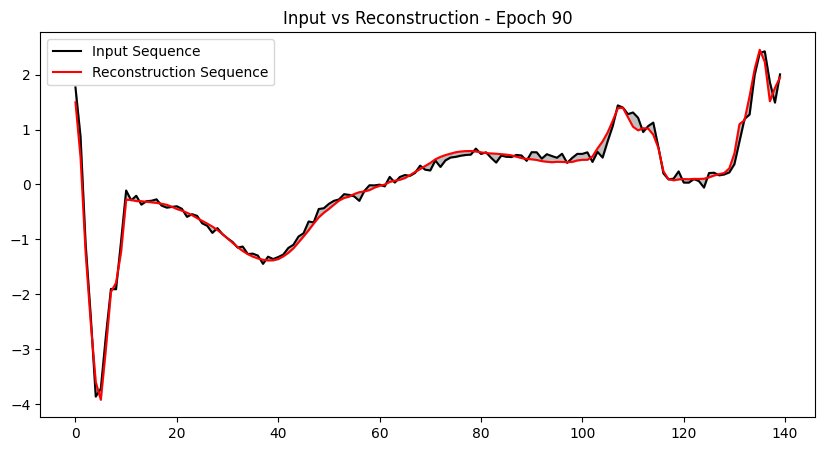

Epoch 91: Train Loss 9.0220, Val Loss 10.1415, Train Acc 82.09%, Val Acc 78.20%
No improvement. Patience 6/10
Epoch 92: Train Loss 8.5964, Val Loss 9.5587, Train Acc 83.63%, Val Acc 80.54%
Saving best model.
Epoch 93: Train Loss 8.4328, Val Loss 9.5097, Train Acc 84.23%, Val Acc 80.77%
Saving best model.
Epoch 94: Train Loss 8.3899, Val Loss 9.5672, Train Acc 84.37%, Val Acc 80.52%
No improvement. Patience 1/10
Epoch 95: Train Loss 8.3823, Val Loss 9.5424, Train Acc 84.42%, Val Acc 80.70%
No improvement. Patience 2/10


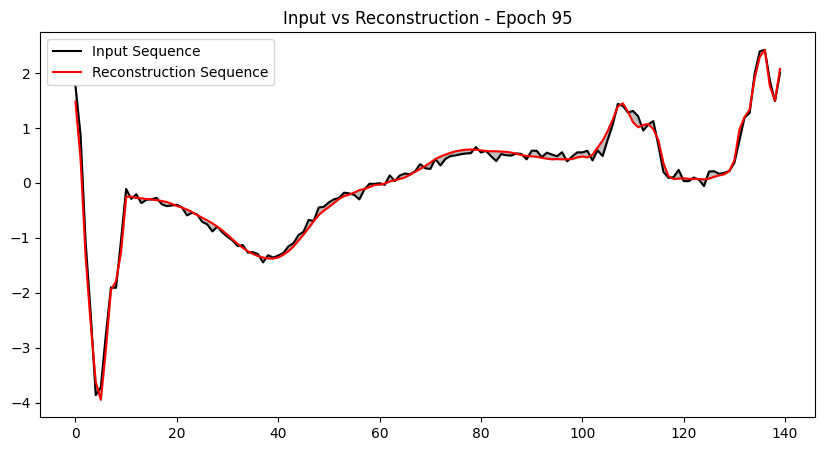

Epoch 96: Train Loss 8.3928, Val Loss 9.5546, Train Acc 84.28%, Val Acc 80.49%
No improvement. Patience 3/10
Epoch 97: Train Loss 8.3115, Val Loss 9.5447, Train Acc 84.69%, Val Acc 80.66%
No improvement. Patience 4/10
Epoch 98: Train Loss 8.2693, Val Loss 9.4910, Train Acc 84.81%, Val Acc 80.76%
Saving best model.
Epoch 99: Train Loss 8.2543, Val Loss 9.4886, Train Acc 84.84%, Val Acc 80.81%
Saving best model.
Epoch 100: Train Loss 8.2455, Val Loss 9.3985, Train Acc 84.89%, Val Acc 81.35%
Saving best model.


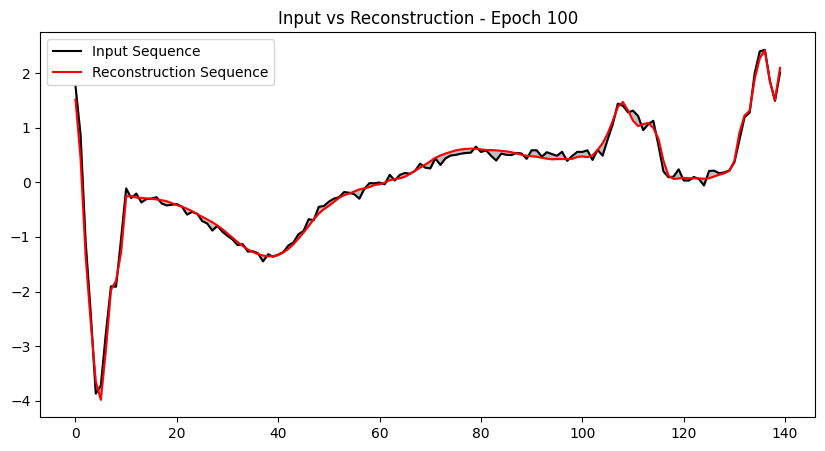

In [36]:
save_path = '/kaggle/working/lstm_auto_encoder.pth'
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=100,
    save_path=save_path,
    patience=10,
    tolerance=0.1
)



In [38]:
import torch.onnx

# Save the model as ONNX format
dummy_input = torch.randn(1, seq_len, n_features).to(device)
onnx_file_path = "/kaggle/working/lstm_autoencoder.onnx"
torch.onnx.export(model, dummy_input, onnx_file_path, verbose=True)


Exported graph: graph(%onnx::Reshape_0 : Float(1, 140, 1, strides=[140, 1, 1], requires_grad=0, device=cuda:0),
      %decoder.output_layer.weight : Float(1, 256, strides=[256, 1], requires_grad=1, device=cuda:0),
      %decoder.output_layer.bias : Float(1, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::LSTM_403 : Float(1, 1024, 1, strides=[1024, 1, 1], requires_grad=0, device=cuda:0),
      %onnx::LSTM_404 : Float(1, 1024, 256, strides=[262144, 256, 1], requires_grad=0, device=cuda:0),
      %onnx::LSTM_405 : Float(1, 2048, strides=[2048, 1], requires_grad=0, device=cuda:0),
      %onnx::LSTM_425 : Float(1, 512, 256, strides=[131072, 256, 1], requires_grad=0, device=cuda:0),
      %onnx::LSTM_426 : Float(1, 512, 128, strides=[65536, 128, 1], requires_grad=0, device=cuda:0),
      %onnx::LSTM_427 : Float(1, 1024, strides=[1024, 1], requires_grad=0, device=cuda:0),
      %onnx::LSTM_448 : Float(1, 512, 128, strides=[65536, 128, 1], requires_grad=0, device=cuda:0),
      %onn

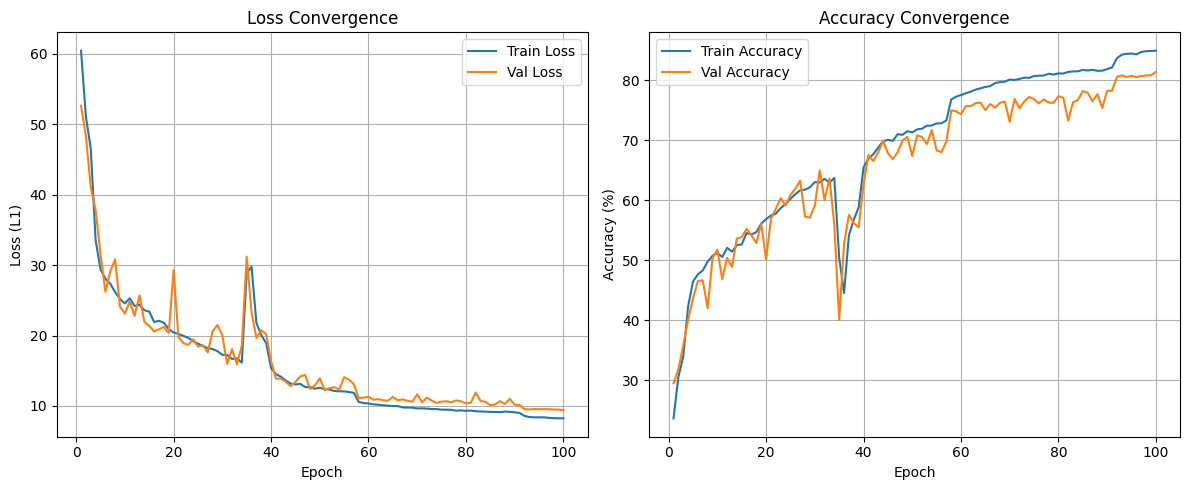

In [40]:
# Plot convergence
plot_convergence(history, save_path='/kaggle/working/convergence_plot_lstm_auto_encoder.png')


In [49]:
print(type(normal_df))
print(len(normal_df))
print(np.array(normal_df).shape)
print(normal_df[0])


<class 'pandas.core.frame.DataFrame'>
2919
(2919, 140)
0      -0.112522
1      -1.100878
2      -0.567088
3       0.490473
4       0.800232
          ...   
3122   -3.107567
3123   -1.693958
3124   -2.089921
3125   -2.123972
3126   -1.553834
Name: 0, Length: 2919, dtype: float64


In [53]:
# Extract the embeddings from the encoder for both normal and anomalous ECGs
model.eval()  # Set model to evaluation mode

normal_embeddings = []
anomaly_embeddings = []

# Extract embeddings for the normal ECG data
normal_embeddings = []

for i in range(len(normal_df)):
    normal_data = normal_df.iloc[i].values  # Get one row as a NumPy array
    normal_data = normal_data.reshape(seq_len, n_features)  # Reshape to [140, 1]
    normal_tensor = torch.tensor(normal_data).unsqueeze(0).float().to(device)  # Add batch dim: [1, 140, 1]
    embedding = model.encoder(normal_tensor).cpu().detach().numpy().squeeze(0)
    normal_embeddings.append(embedding)


# Extract embeddings for the anomaly ECG data
for i in range(len(anomaly_df)):
    anomaly_data = anomaly_df.iloc[i].values  # Get the row as a numpy array
    anomaly_data = anomaly_data.reshape(seq_len, n_features)  # Reshape to (140, 1)
    anomaly_tensor = torch.tensor(anomaly_data).unsqueeze(0).float().to(device)  # Shape: [1, 140, 1]
    embedding = model.encoder(anomaly_tensor).cpu().detach().numpy().squeeze(0)
    anomaly_embeddings.append(embedding)



# Combine the embeddings for both normal and anomaly data
# Combine the embeddings for both normal and anomaly data
embeddings = np.vstack(normal_embeddings + anomaly_embeddings)
labels = [0] * len(normal_embeddings) + [1] * len(anomaly_embeddings)  # 0 = normal, 1 = anomaly




In [52]:
# tep 2: Apply t-SNE
# Next, we will apply t-SNE to reduce the dimensions of the embeddings from 128 (or whatever your embedding size is) to 2 for visualization.

# python
# Copy
# Edit
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Prepare the 2D t-SNE coordinates
tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
tsne_df["Label"] = labels

ValueError: Found array with dim 3. TSNE expected <= 2.

In [ ]:
import plotly.express as px

# Create an interactive 2D plot
fig = px.scatter(tsne_df, x="TSNE1", y="TSNE2", color="Label", 
                 labels={"Label": "ECG Type"},
                 title="t-SNE Visualization of ECG Embeddings (Normal vs Anomalous)",
                 color_discrete_map={0: 'blue', 1: 'red'})

# Show the plot
fig.show()
fig = px.scatter(tsne_df, x="TSNE1", y="TSNE2", color="Label", 
                 labels={"Label": "ECG Type"},
                 title="t-SNE Visualization of ECG Embeddings (Normal vs Anomalous)",
                 color_discrete_map={0: 'blue', 1: 'red'},
                 hover_data=["Label"])  # Hover data to show labels

# Show the interactive plot
fig.show()
fig.write_html("ecg_tsne_plot.html")


### validation

In [54]:

# Run validation
model.load_state_dict(torch.load('/kaggle/working/lstm_auto_encoder.pth'))  # Load best model
reconstruction_errors = validate_model(model, test_normal_dataset, tolerance=0.1, device='cuda')

Validation Loss: 9.1143, Validation Accuracy: 82.44%
Mean Reconstruction Error: 0.0651
Std Reconstruction Error: 0.0849


### test on abnormal ecg

In [55]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report



# Set the threshold
threshold = 0.2197
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Run anomaly detection
normal_errors, normal_preds = get_reconstruction_errors(model, test_normal_dataset, threshold, device='cuda')
anomaly_errors, anomaly_preds = get_reconstruction_errors(model, test_anomaly_dataset, threshold, device='cuda')

# Combine for full evaluation
all_preds = np.concatenate([normal_preds, anomaly_preds])
true_labels = np.concatenate([
    np.zeros(len(normal_preds)),  # normal = 0
    np.ones(len(anomaly_preds))   # abnormal = 1
])

# Evaluate
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, all_preds, average='binary')
print(f"\n📊 Evaluation on Mixed Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Full classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, all_preds, target_names=["Normal", "Anomaly"], digits=4))


Anomaly Detection Threshold: 0.2197

📊 Evaluation on Mixed Test Set:
Precision: 0.9962
Recall:    0.5238
F1-Score:  0.6866

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.1144    0.9686    0.2046     18480
     Anomaly     0.9962    0.5238    0.6866    291060

    accuracy                         0.5504    309540
   macro avg     0.5553    0.7462    0.4456    309540
weighted avg     0.9436    0.5504    0.6579    309540



## model 2 : gru auto encoder

### model architecture

In [2]:
class GRUEncoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(GRUEncoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.gru1 = nn.GRU(input_size=n_features, hidden_size=self.hidden_dim, batch_first=True)
        self.gru2 = nn.GRU(input_size=self.hidden_dim, hidden_size=embedding_dim, batch_first=True)

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, _ = self.gru1(x)
        x, hidden_n = self.gru2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))


NameError: name 'nn' is not defined

In [58]:
class GRUDecoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(GRUDecoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.gru1 = nn.GRU(input_size=input_dim, hidden_size=input_dim, batch_first=True)
        self.gru2 = nn.GRU(input_size=input_dim, hidden_size=self.hidden_dim, batch_first=True)

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)


In [59]:
class GRUAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(GRUAutoencoder, self).__init__()
        self.encoder = GRUEncoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = GRUDecoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### training

In [1]:
save_path = '/kaggle/working/gru_auto_encoder.pth'
model3GRU = GRUAutoencoder(seq_len, n_features, 128)
model3GRU = model3GRU.to(device)
model3GRU, history3 = train_model(
    model3GRU,
    train_dataset,
    val_dataset,
    n_epochs=100,
    save_path=save_path,
    patience=10,
    tolerance=0.1
)



NameError: name 'GRUAutoencoder' is not defined

In [ ]:

# Plot convergence
plot_convergence(history3, save_path='convergence_plot_gru_auto_encoder.png')


### validation

In [ ]:

# Run validation
model3GRU.load_state_dict(torch.load('/kaggle/working/gru_auto_encoder.pth'))  # Load best model
reconstruction_errors = validate_model(model3GRU, test_normal_dataset, tolerance=0.1, device='cuda')

### test on abnormal ecg

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report



# Set the threshold
threshold = 0.2197
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Run anomaly detection
normal_errors, normal_preds = get_reconstruction_errors(model3GRU, test_normal_dataset, threshold, device='cuda')
anomaly_errors, anomaly_preds = get_reconstruction_errors(model3GRU, test_anomaly_dataset, threshold, device='cuda')

# Combine for full evaluation
all_preds = np.concatenate([normal_preds, anomaly_preds])
true_labels = np.concatenate([
    np.zeros(len(normal_preds)),  # normal = 0
    np.ones(len(anomaly_preds))   # abnormal = 1
])

# Evaluate
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, all_preds, average='binary')
print(f"\n📊 Evaluation on Mixed Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Full classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, all_preds, target_names=["Normal", "Anomaly"], digits=4))


prediction part :

In [ ]:
import torch
import numpy as np

# Load the LSTM Autoencoder model
lstm_model = LSTMAutoencoder(input_size, hidden_dim, embedding_dim).to(device)
lstm_model.load_state_dict(torch.load('best_lstm_autoencoder.pth'))
lstm_model.eval()

def detect_anomalies_lstm(model, test_loader, threshold_percentile=95):
    model.eval()
    reconstruction_errors = []
    true_labels = []

    with torch.no_grad():
        for data in test_loader:  # test_loader should contain both normal and anomalous ECG sequences
            inputs, labels = data
            inputs = inputs.to(device)
            true_labels.extend(labels.cpu().numpy())
            
            # Get the reconstructed inputs from the model
            reconstructed = model(inputs)
            
            # Compute reconstruction error (MSE)
            error = ((inputs - reconstructed) ** 2).mean(dim=1).cpu().numpy()  # MSE per sample
            reconstruction_errors.extend(error)
    
    # Choose a threshold based on the 95th percentile of training errors
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    
    # Classify anomalies
    predictions = [1 if error > threshold else 0 for error in reconstruction_errors]
    
    # Calculate precision, recall, and ROC-AUC score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, reconstruction_errors)

    print(f"LSTM Precision: {precision}")
    print(f"LSTM Recall: {recall}")
    print(f"LSTM F1 Score: {f1}")
    print(f"LSTM ROC-AUC Score: {roc_auc}")

# Example usage with test_loader containing both normal and anomaly data
detect_anomalies_lstm(lstm_model, test_loader)


In [ ]:
# Load the GRU Autoencoder model
gru_model = GRUAutoencoder(input_size, hidden_dim, embedding_dim).to(device)
gru_model.load_state_dict(torch.load('best_gru_autoencoder.pth'))
gru_model.eval()

def detect_anomalies_gru(model, test_loader, threshold_percentile=95):
    model.eval()
    reconstruction_errors = []
    true_labels = []

    with torch.no_grad():
        for data in test_loader:  # test_loader should contain both normal and anomalous ECG sequences
            inputs, labels = data
            inputs = inputs.to(device)
            true_labels.extend(labels.cpu().numpy())
            
            # Get the reconstructed inputs from the model
            reconstructed = model(inputs)
            
            # Compute reconstruction error (MSE)
            error = ((inputs - reconstructed) ** 2).mean(dim=1).cpu().numpy()  # MSE per sample
            reconstruction_errors.extend(error)
    
    # Choose a threshold based on the 95th percentile of training errors
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    
    # Classify anomalies
    predictions = [1 if error > threshold else 0 for error in reconstruction_errors]
    
    # Calculate precision, recall, and ROC-AUC score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, reconstruction_errors)

    print(f"GRU Precision: {precision}")
    print(f"GRU Recall: {recall}")
    print(f"GRU F1 Score: {f1}")
    print(f"GRU ROC-AUC Score: {roc_auc}")

# Example usage with test_loader containing both normal and anomaly data
detect_anomalies_gru(gru_model, test_loader)
